In [18]:
!pip install tensorflow
!pip install scikit-learn

In [102]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import io
import seaborn as sns
import pandas as pd

In [20]:
tf.__version__

'2.18.0'

In [44]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
logdir='log'

In [23]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [56]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
            y=train_labels,
            epochs=5,
            validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8900 - loss: 0.3578 - val_accuracy: 0.9857 - val_loss: 0.0416
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9841 - loss: 0.0510 - val_accuracy: 0.9887 - val_loss: 0.0320
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9891 - loss: 0.0336 - val_accuracy: 0.9904 - val_loss: 0.0286
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9922 - loss: 0.0236 - val_accuracy: 0.9912 - val_loss: 0.0257
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9937 - loss: 0.0189 - val_accuracy: 0.9870 - val_loss: 0.0451


In [64]:
y_true=test_labels
y_pred_probabilities=model.predict(test_images)
y_pred=np.argmax(y_pred_probabilities, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [66]:
classes=[0,1,2,3,4,5,6,7,8,9]

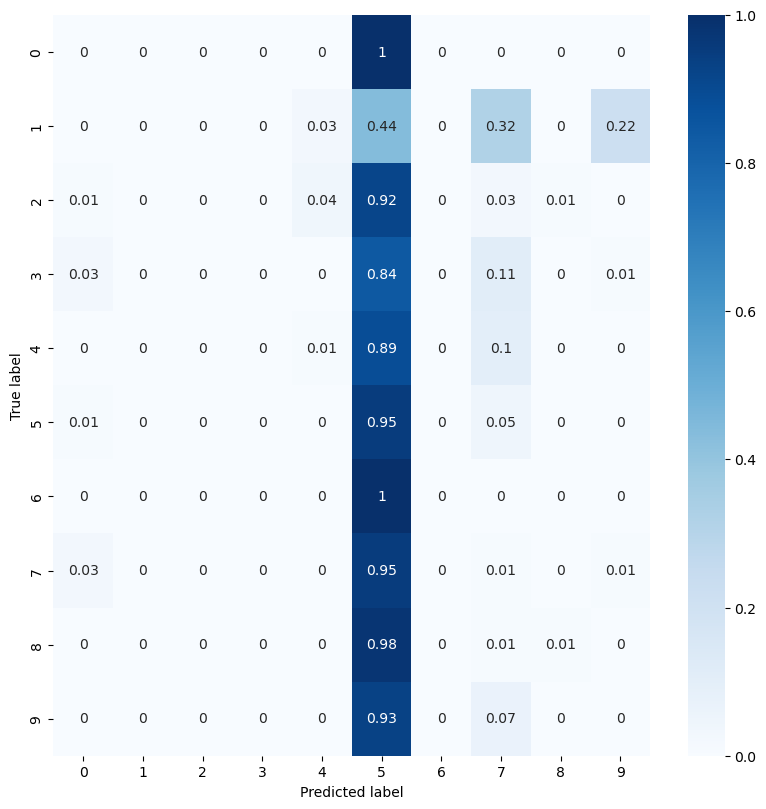

In [68]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [80]:
model1 = models.Sequential()
model1.add(layers.Input(shape=(28, 28, 1)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [96]:
file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_probabilities = model1.predict(test_images)
  test_pred=np.argmax(test_pred_probabilities, axis=1)

  con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)

  # Log the confusion matrix as an image summary.
  with file_writer.as_default():
    tf.summary.image("Confusion Matrix", image, step=epoch)


logdir='logs/images'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [104]:
model1.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [106]:
# Start TensorBoard.
%tensorboard --logdir logs/images

In [114]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)  
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)  
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (weighted): {precision:.2f}")
print(f"Sensitivity (Recall) (weighted): {recall:.2f}")
print(f"F1-Score (weighted): {f1:.2f}")

Confusion Matrix:
[[  0   0   0   0   1 979   0   0   0   0]
 [  4   0   0   0  29 496   0 359   0 247]
 [ 10   0   0   0  39 945   0  30   8   0]
 [ 29   0   0   0   5 850   0 114   2  10]
 [  0   0   0   0  13 870   0  98   0   1]
 [  5   0   0   0   0 843   0  41   1   2]
 [  0   0   0   0   0 957   0   1   0   0]
 [ 35   0   1   0   4 974   0   6   0   8]
 [  1   0   0   0   1 954   0  12   6   0]
 [  0   0   0   0   4 935   0  70   0   0]]
Accuracy: 0.09
Precision (weighted): 0.06
Sensitivity (Recall) (weighted): 0.09
F1-Score (weighted): 0.02
